# Table of Contents
* [1. Introduction](#1.-Introduction)
* [2. Benchmark Cases](#2.-Benchmark-Cases)
	* [2.1 Dispersion Tensor Plots](#2.1-Dispersion-Tensor-Plots)
		* [2.1.1 Cold Dispersion Relation](#2.1.1-Cold-Dispersion-Relation)
		* [2.1.2 Relativistic Dispersion Relation](#2.1.2-Relativistic-Dispersion-Relation)


# 1. Introduction

A good benchmark for our Plamsa Dispersion Function module is to calculate the dispersion properties for certain waves. This document provide a demostration of some of these benchmarks. We are going to use functions provided in module `FPSDP.Models.Waves.DispersionRelation`.

Our first benchmark will be against some plots given in <a name="ref-1"/>[(Bindslev, 1992)](#cite-Bindslev1992). Several plots similar to Fig.1 in <a name="ref-2"/>[(Bindslev, 1992)](#cite-Bindslev1992) will be produced and discussed.

> Fig.1 in <a name="ref-3"/>[(Bindslev, 1992)](#cite-Bindslev1992):

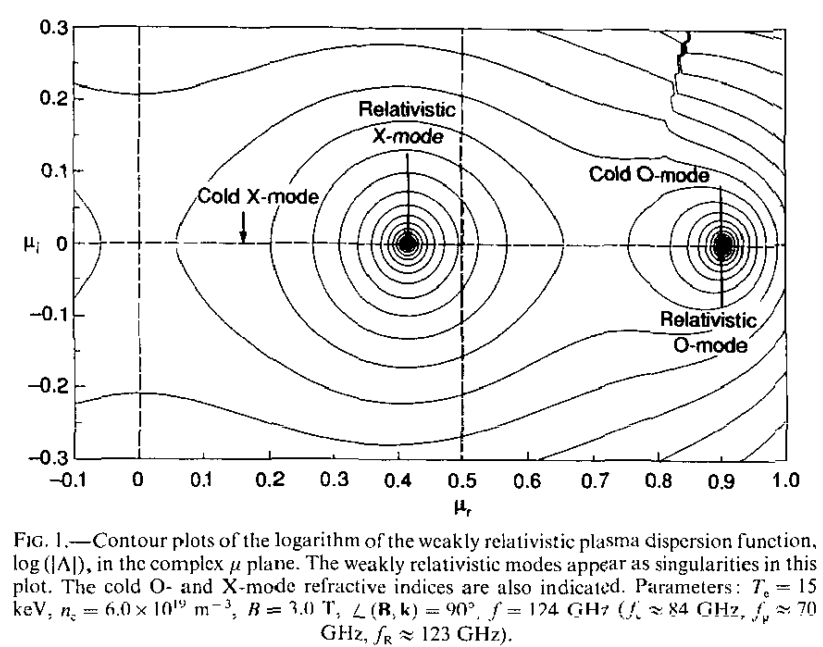

In [68]:
from IPython.display import Image
Image(filename="Plots/Bindslev1992_Fig1.png")

The basic idea of these plots is to plot the plasma dispersion tensor $\bf{\Lambda}$ as a function of refactive index $\vec{n}$. Detailed discussion of these quantities can be found in <a name="ref-4"/>[(Stix, 1992)](#cite-Stix1992).

# 2. Benchmark Cases

## 2.1 Dispersion Tensor Plots

First, let's prepare the environment. We import some relevant modules, and some physical constants.

In [69]:
%matplotlib inline

import matplotlib.pyplot as plt
import pylab
import numpy as np

import FPSDP.Models.Waves.DispersionRelation as dr
import FPSDP.Plasma.DielectricTensor as dt
import FPSDP.Plasma.Analytical_Profiles.TestParameter as tp
from FPSDP.GeneralSettings.UnitSystem import cgs

pylab.rcParams['figure.figsize'] = (10.0, 8.0)
pylab.rcParams['font.size'] = 20

c = cgs['c']
m_e = cgs['m_e']
e = cgs['e']
keV = cgs['keV']
pi = np.pi

Now, we use the plasma parameters exactly the same as in <a name="ref-5"/>[(Bindslev, 1992)](#cite-Bindslev1992). Note that in the paper, all quantities are in SI unit, but we are using Gaussian unit here.

In [70]:
tp.set_parameter1D(ne_shape='uniform', ne_0=6.0e13, Te_shape='uniform', 
                   Te_0=15*keV, B_0=3.0e4)
                   
p1d = tp.create_profile1D()
p1d.setup_interps()

We will try several kinds of dielectric tensors. One with cold electron, and some with weakly relativistic electron.

In [71]:
c_dielect = dt.ColdElectronColdIon(p1d)
r_dielect_1 = dt.RelElectronColdIon(p1d, max_harmonic=1, max_power=5)
r_dielect_2 = dt.RelElectronColdIon(p1d, max_harmonic=2, max_power=5)
r_dielect_3 = dt.RelElectronColdIon(p1d, max_harmonic=3, max_power=5)
r_dielect_1_1 = dt.RelElectronColdIon(p1d, max_harmonic=1, max_power=1)

We have created 3 relativistic dielectric tensors with same `max_power = 5`, but different `max_harmonic` values. We will investigate how this will affect the plot. For comparison, we also generated a dielectric tensor with `max_power=1`.

In [72]:
omega = 124e9 * 2*pi
k_para = 0
n_perp_r = np.linspace(-0.1, 1, 1000)
n_perp_i = np.linspace(-0.3, 0.3, 500)
k_perp_r = omega/c*n_perp_r
k_perp_i = omega/c*n_perp_i

k_perp = k_perp_r[np.newaxis, :] + 1j*k_perp_i[:, np.newaxis]

coordinates = [tp.Parameter1D['R_0']]

c_Lambd = dr.Lambda(omega, k_para, k_perp, c_dielect, coordinates)
r_Lambd1 = dr.Lambda(omega, k_para, k_perp, r_dielect_1, coordinates)
r_Lambd2 = dr.Lambda(omega, k_para, k_perp, r_dielect_2, coordinates)
r_Lambd3 = dr.Lambda(omega, k_para, k_perp, r_dielect_3, coordinates)
r_Lambd11 = dr.Lambda(omega, k_para, k_perp, r_dielect_1_1, coordinates)

### 2.1.1 Cold Dispersion Relation

Now let's plot the cold one. Note that we want to plot the logrithm of $\Lambda$.

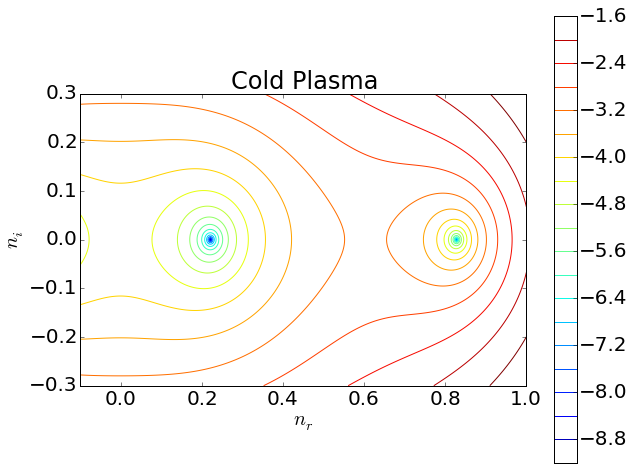

In [73]:
fig = plt.figure()
plt.contour(np.log(np.abs(c_Lambd)), 20, extent=[-0.1, 1, -0.3, 0.3])
plt.colorbar()
plt.title('Cold Plasma')
plt.xlabel('$n_r$')
plt.ylabel('$n_i$')
fig.axes[0].set_aspect(1.2)


We can quickly check the locations of the poles. Since in cold plasma, we have analytical expressions for X and O mode dispersion relations.

$$ n^2_{X} = \frac{S^2-D^2}{S}$$ and $$n^2_{O}=P$$

where $S\equiv Re(\epsilon_{xx})$, $D \equiv -Im(\epsilon_{xy})$, and $P\equiv Re(\epsilon_{zz})$.

In [74]:
eps_cold = c_dielect.epsilon(coordinates, omega)
S = np.real(eps_cold[0,0])
D = -np.imag(eps_cold[0,1])
P = np.real(eps_cold[2,2])
nx = np.sqrt((S*S-D*D)/S)
no = np.sqrt(P)
print('nx = {}, no = {}'.format(nx, no))

nx = 0.221678394304, no = 0.827901630565


We can see the two poles in the plot are indeed located at the predicted locations. 

> However, the $n_X$ and $n_O$ locations we obtained are not quite the same as indicated in Fig.1 of <a name="ref-6"/>[(Bindslev, 1992)](#cite-Bindslev1992). The reason of this discrepancy needs further investigation. 

We can double check the number using Bindslev's parameters given in caption of Fig.1, i.e. $f_p \approx 70\text{GHz}$. So, for cold plasma, $P = 1-\frac{f_p^2}{f^2} \approx 0.6813$. Then, $n_O = \sqrt(P) \approx 0.8254$. This estimation agrees with our plot.

### 2.1.2 Relativistic Dispersion Relation

Now we move on to weakly relativistic cases. First, let's plot them and take a look.

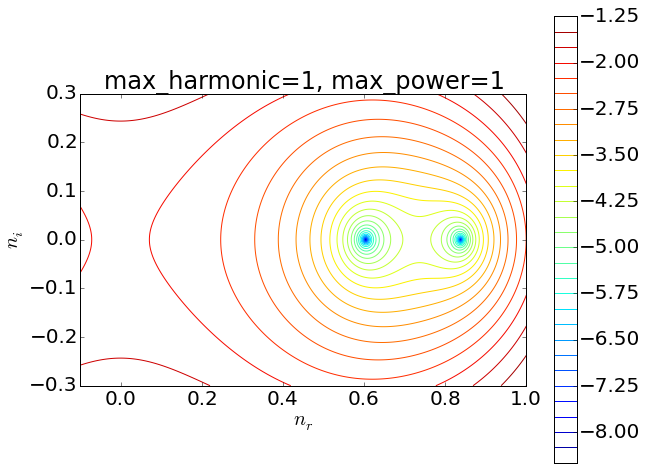

In [75]:
fig = plt.figure()
plt.contour(np.log(np.abs(r_Lambd11)), 30, extent=[-0.1, 1, -0.3, 0.3])
plt.colorbar()
plt.title('max_harmonic=1, max_power=1')
plt.xlabel('$n_r$')
plt.ylabel('$n_i$')
fig.axes[0].set_aspect(1.2)

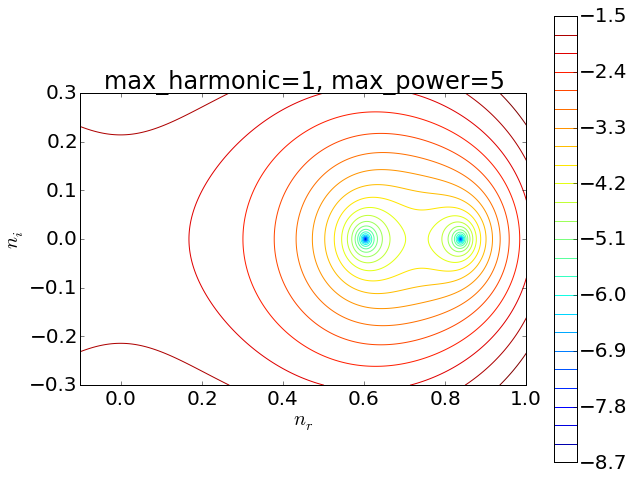

In [76]:
fig = plt.figure()
plt.contour(np.log(np.abs(r_Lambd1)), 30, extent=[-0.1, 1, -0.3, 0.3])
plt.colorbar()
plt.title('max_harmonic=1, max_power=5')
plt.xlabel('$n_r$')
plt.ylabel('$n_i$')
fig.axes[0].set_aspect(1.2)

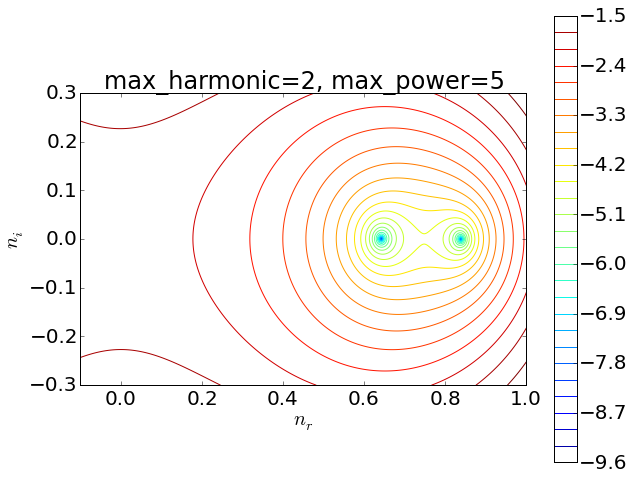

In [77]:
fig = plt.figure()
plt.contour(np.log(np.abs(r_Lambd2)), 30, extent=[-0.1, 1, -0.3, 0.3])
plt.colorbar()
plt.title('max_harmonic=2, max_power=5')
plt.xlabel('$n_r$')
plt.ylabel('$n_i$')
fig.axes[0].set_aspect(1.2)

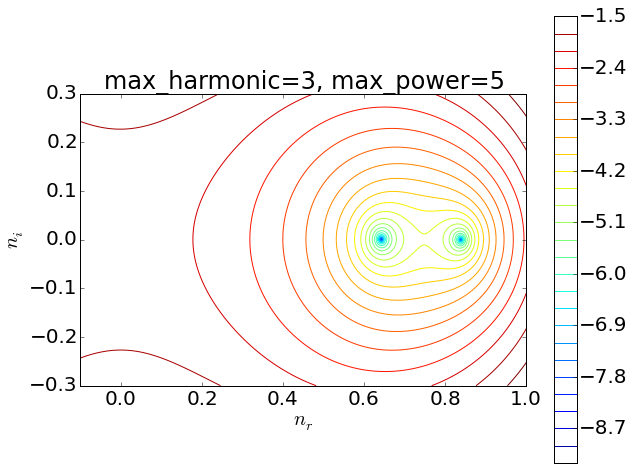

In [78]:
fig = plt.figure()
plt.contour(np.log(np.abs(r_Lambd3)), 30, extent=[-0.1, 1, -0.3, 0.3])
plt.colorbar()
plt.title('max_harmonic=3, max_power=5')
plt.xlabel('$n_r$')
plt.ylabel('$n_i$')
fig.axes[0].set_aspect(1.2)

- The first thing we observe is the significant shift of the pole corresponding to X-mode dispersion relation. 

> This feature quanlitatively agree with Fig.1 of <a name="ref-7"/>[(Bindslev, 1992)](#cite-Bindslev1992). However, the exact locations are still not the same. 

- We also see that increasing `max_power` from 1 to 5 doesn't introduce much of a difference. This is expected since $\lambda$ is small in our case.
- We do see some changes when increasing `max_harmonic` from 1 to 2. Since $f_{ce} = 84\text{GHz}$ and $f=124\text{GHz}$, the second harmonic is indeed the most significant correction we should see.
- Going to 3rd harmonic doesn't have much effect. Again, this is expected since our frequency is further away from the 3rd harmonic frequency.

<!--bibtex

@article{Bindslev1992,
author = {Bindslev, H.},
file = {:C$\backslash$:/Users/lei/Google Drive/Project Related/Potential Diagnostics/relfectometry/Academic Papers/Bindslev{\_}relativistic{\_}effects{\_}reflectometry.pdf:pdf},
journal = {Plasma Physics and Controlled Fusion},
mendeley-groups = {Reflectometry},
number = {11},
pages = {1601--1618},
title = {{Relativistic effects in plasma reflectometry}},
volume = {34},
year = {1992}
}

@book{Stix1992,
address = {New York},
author = {Stix, Thomas Howard},
file = {:C$\backslash$:/Users/lei/Google Drive/books/WavesinPlasmas{\_}Stix.djvu:djvu},
isbn = {9780883188590},
publisher = {American Inst. of Physics},
title = {{Waves in Plasmas}},
year = {1992}
}

-->

# References

<a name="cite-Bindslev1992"/><sup>[^](#ref-1) [^](#ref-2) [^](#ref-3) [^](#ref-5) [^](#ref-6) [^](#ref-7) </sup>Bindslev, H.. 1992. _Relativistic effects in plasma reflectometry_.

<a name="cite-Stix1992"/><sup>[^](#ref-4) </sup>Stix, Thomas Howard. 1992. _Waves in Plasmas_.

